In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.plot_calibration import plot_calibration_for_score_on_problem

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


Read in data, preprocess it

In [2]:
kentucky_arnold = pd.read_csv("kentucky/data/processed/kentucky_data.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    kentucky_arnold = kentucky_arnold.replace({decoder_name: decoder_dict})

kentucky_arnold.rename(columns=settings['decoders']['label'], inplace=True)
kentucky_arnold.rename(columns=settings['decoders']['arnold_name'], inplace=True)

In [3]:
# compute scaled arnold scores 
for score in ['arnold_nca', 'arnold_nvca', 'arnold_fta']:
    kentucky_arnold[score] = kentucky_arnold[score + "_raw"]
    kentucky_arnold = kentucky_arnold.replace({score: settings[score + '_scaler'] })
    if score != 'arnold_nvca':
        kentucky_arnold[score] = kentucky_arnold[score].astype(int)

In [5]:
kentucky_arnold = kentucky_arnold[['person_id', 'screening_date', 
                                        'arnold_nca_raw', 'arnold_nca', 
                                        'arnold_nvca_raw', 'arnold_nvca', 
                                        'sex', 'race'] 
                                       + settings["labels"]]

# wide to long on sensitive attrs
kentucky_long = (pd.melt(kentucky_arnold, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                         .rename({'variable': 'Attribute',
                                  'value': 'Attribute Value'},
                                   axis=1))
kentucky_long = kentucky_long.merge(kentucky_arnold.drop(columns=['sex', 'race']),
                                                    on = ['person_id', 'screening_date'],
                                                    how = 'left')
kentucky_long.head()

,person_id,screening_date,Attribute,Attribute Value,arnold_nca_raw,arnold_nca,arnold_nvca_raw,arnold_nvca,general_two_year,general_six_month,drug_two_year,property_two_year,misdemeanor_two_year,felony_two_year,violent_two_year,drug_six_month,property_six_month,misdemeanor_six_month,felony_six_month,violent_six_month
0,5,2015-06-28,sex,male,5,4,4,Yes,0,0,0,0,0,0,0,0,0,0,0,0
1,8,2016-05-02,sex,male,10,6,3,No,1,1,0,0,1,1,0,0,0,0,1,0
2,12,2015-07-22,sex,male,2,2,1,No,0,0,0,0,0,0,0,0,0,0,0,0
3,23,2015-03-29,sex,male,5,4,2,No,0,0,0,0,0,0,0,0,0,0,0,0
4,27,2016-04-27,sex,male,6,4,3,No,1,1,1,0,1,0,1,1,0,1,0,0


## Calibration of Arnold PSA

First type of calibration: score of model should be reflective of true probability of recid

$P(Y = 1 | Score = score) = score$

Second type of calibration: calibration across groups should be the same 

$P(Y=1|S=s,G=g_1)=P(Y=1|S=s,G=g_2)$

Idea: plot overall calibration curve in bold black, and plot calibration curves for each group (race, sex) in different colors 

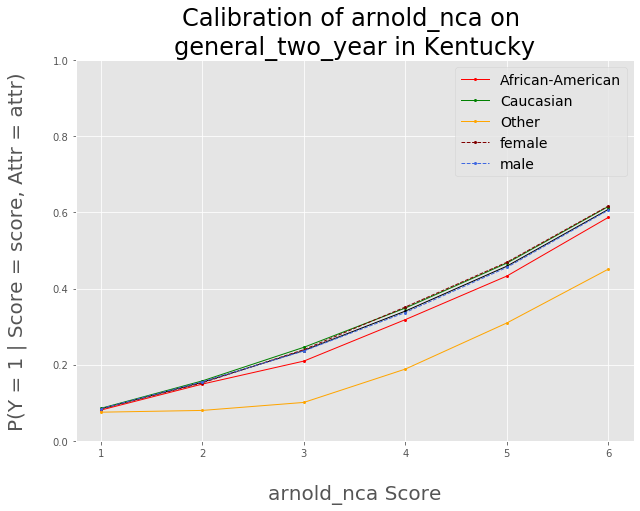

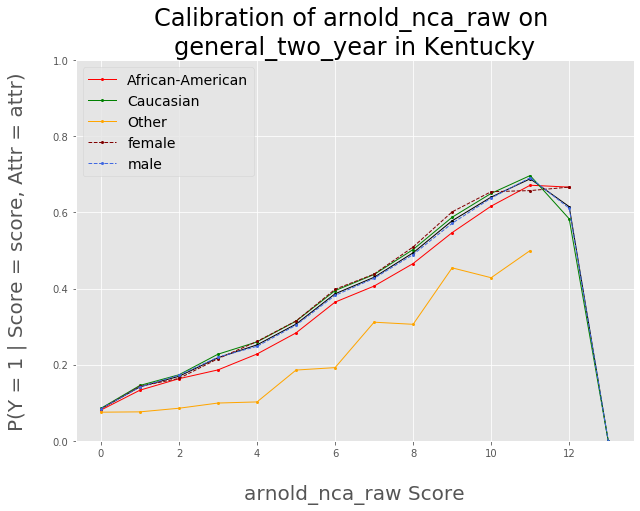

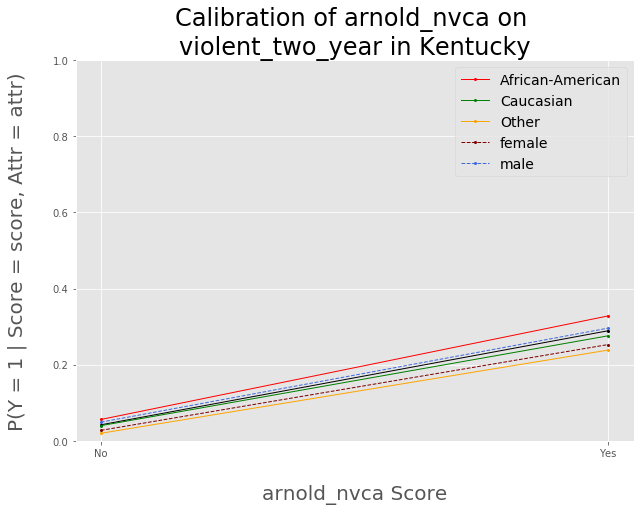

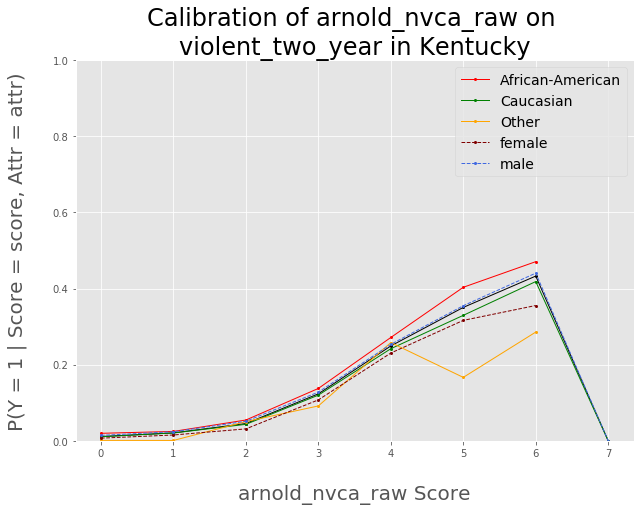

In [6]:
# calibration of PSA
scores_problem_dict = {'arnold_nca': ['general_two_year',
                                      'kentucky/logs/fairness_results/calibration_visualizations/arnold_nca_calib.pdf'],
                       'arnold_nca_raw': ['general_two_year', 
                                          'kentucky/logs/fairness_results/calibration_visualizations/arnold_nca_raw_calib.pdf'],
                       'arnold_nvca': ['violent_two_year', 
                                       'kentucky/logs/fairness_results/calibration_visualizations/arnold_ncva_calib.pdf'], 
                       'arnold_nvca_raw': ['violent_two_year', 
                                           'kentucky/logs/fairness_results/calibration_visualizations/arnold_ncva_raw_calib.pdf']
                      }

for score_name, (problem_name, save_path) in scores_problem_dict.items():
    plot_calibration_for_score_on_problem(long_df=kentucky_long,
                                           problem_name=problem_name,
                                           score_name=score_name,
                                           region="Kentucky",
                                           save_path=save_path)

## Calibration of EBM and RiskSLIM